[View in Colaboratory](https://colab.research.google.com/github/cadurkin/Phytoplankton_Taxomony_Course/blob/master/Example_community_composition_analysis.ipynb)

# Example analysis of phytoplankton community composition

- First import your data.  
- Data should be saved as a .csv file (comma-separated values).
- import libraries needed to analyze the data.  Pandas helps to work with data matrices.  Numpy works with data arrays. Matplotlib is used for plotting.

In [1]:
!pip install scikit-bio
!git clone https://github.com/cadurkin/Phytoplankton_Taxomony_Course.git  # Download data
  
import skbio as skbio
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

data = pd.read_csv('Phytoplankton_Taxomony_Course/Example_Station_M_cellcounts.csv',infer_datetime_format=True,index_col=0)
#display the first 10 rows to make sure it looks ok
data.iloc[0:10]

fatal: destination path 'Phytoplankton_Taxomony_Course' already exists and is not an empty directory.


,Parameter,Sample1,Sample2,Sample3,Sample4,Sample5,Sample6,Sample7,Sample8,Sample9,Sample10,Sample11,Sample12,Sample13,Sample14,Sample15
total_volume_mL,metadata,37,30,29,29,24,27,41,29,23,1.6,1.8,26,25.5,23,28
Dilution_factor,metadata,10,10,10,10,20,3,3,3,10,10.0,10.0,3,4.0,3,2
squares_counted,metadata,12,7,20,12,13,16,25,10,8,10.0,10.0,6,7.0,16,9
Actinoptychus,diatom,5,0,11,1,1,1,1,3,0,2.0,0.0,4,3.0,1,0
Asteromphalus_sarcophagus,diatom,1,0,0,0,0,0,0,1,1,0.0,0.0,0,0.0,0,0
Asteromphalus_circular_60um,diatom,0,0,0,0,3,0,1,1,0,0.0,1.0,0,0.0,0,0
Bacteriastrum,diatom,20,14,0,1,0,0,0,0,0,0.0,4.0,0,0.0,0,0
Cerataulina,diatom,5,0,2,0,0,0,0,0,0,0.0,1.0,0,0.0,5,2
Chaetoceros socialis,diatom,23,4,17,16,0,1,0,0,0,0.0,0.0,0,0.0,0,0
Chaetoceros_affinis-atlanticus,diatom,5,5,6,0,0,0,0,0,0,0.0,0.0,0,0.0,0,0


In [2]:
!ls Phytoplankton_Taxomony_Course

Example_community_composition_analysis.ipynb  README.md
Example_Station_M_cellcounts.csv


<b> Organize data so that cell counts are in separate matrices from metadata

In [44]:
#separate metadata rows and columns from the raw cell counts
cell_counts_andType = data.loc[data.Parameter != 'metadata']
cell_counts = cell_counts_andType.drop('Parameter',axis=1)
#display the top part of the cell count matrix to make sure it looks correct
cell_counts.iloc[0:10]


,Sample1,Sample2,Sample3,Sample4,Sample5,Sample6,Sample7,Sample8,Sample9,Sample10,Sample11,Sample12,Sample13,Sample14,Sample15
Actinoptychus,5,0,11,1,1,1,1,3,0,2.0,0.0,4,3.0,1,0
Asteromphalus_sarcophagus,1,0,0,0,0,0,0,1,1,0.0,0.0,0,0.0,0,0
Asteromphalus_circular_60um,0,0,0,0,3,0,1,1,0,0.0,1.0,0,0.0,0,0
Bacteriastrum,20,14,0,1,0,0,0,0,0,0.0,4.0,0,0.0,0,0
Cerataulina,5,0,2,0,0,0,0,0,0,0.0,1.0,0,0.0,5,2
Chaetoceros socialis,23,4,17,16,0,1,0,0,0,0.0,0.0,0,0.0,0,0
Chaetoceros_affinis-atlanticus,5,5,6,0,0,0,0,0,0,0.0,0.0,0,0.0,0,0
Chaetoceros_decipien,1,6,0,0,0,0,0,0,0,0.0,1.0,0,0.0,5,0
Chaetoceros_didymus,0,0,0,0,0,0,0,0,0,0.0,2.0,0,0.0,0,0
Chaetoceros_concavicornus,3,0,11,2,49,14,0,11,14,0.0,1.0,21,18.0,0,0


In [45]:
#Create matrix with all the metadata
metadata_andType = data.loc[data.Parameter == 'metadata']
metadata = metadata_andType.drop('Parameter',axis=1)
metadata

,Sample1,Sample2,Sample3,Sample4,Sample5,Sample6,Sample7,Sample8,Sample9,Sample10,Sample11,Sample12,Sample13,Sample14,Sample15
total_volume_mL,37,30,29,29,24,27,41,29,23,1.6,1.8,26,25.5,23,28
Dilution_factor,10,10,10,10,20,3,3,3,10,10.0,10.0,3,4.0,3,2
squares_counted,12,7,20,12,13,16,25,10,8,10.0,10.0,6,7.0,16,9
Total_counted,457,630,954,434,421,502,737,642,543,740.0,661.0,405,521.0,1026,1021


## Calculate the cell concentrations
- Divide cell counts by the number of sedwick rafter squares counted to calculate cells per uL.  One square = 1 microliter of sample.
- Multiply the cells per uL by the dilution or concentration factor, whichever is appropriate.  In this dataset, highly concentrated samples were diluted.  If you settled cells into a smaller volume, you will need to use the dilution factor.  For example, 1 mL concentrated from 10 mL = 0.1 dilution factor.


In [0]:
cells_per_uL = cell_counts.divide(metadata.loc['squares_counted'], axis = 1)
cells_per_uL_dilutionCorrected = cells_per_uL.multiply(metadata.loc['Dilution_factor'], axis = 1)

In [0]:
#convert the cell concentration to cells per mL
cells_per_mL = cells_per_uL_dilutionCorrected.multiply(1000)

## Calculate Bray-Curtis dissimilarity index matrix
- using scipy library of functions
- "pdist" calculates the pairwise distance between all samples using a chosen metric.  Here, we are using the Bray-Curtis similary metric.
- the pdist function requires an array with samples as the columns and species as the rows.  So, we need to transform our species abundance matrix using the pandas function ".T".  
- For the "pdist" function to work, the species abundance matrix also needs to be converted to an "array", which does not have any labels in the rows or columns.
- later we will need our similarity matrix to be in a "square" form, instead of the condensed output that pdist provides by default.  The squareform function converts the condensed matrix into a square.
- The functions used in later steps will also require the similarity matrix to be in a specialized "distance matrix" format used by that function.  The last line of code here converts our square matrix into a distance matrix that includes the sample IDs.

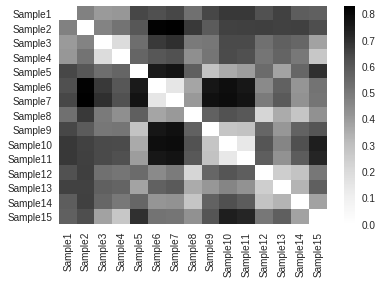

In [51]:
from scipy.spatial.distance import pdist
from scipy.spatial.distance import squareform

bc_matrix_condensed = pdist(np.asarray(cells_per_mL.T),metric = 'braycurtis')
bc_matrix_square = squareform(bc_matrix_condensed)

sample_list = np.asarray(cell_counts.T.index)
bc_matrix = skbio.stats.distance.DistanceMatrix(data = bc_matrix_square,ids=sample_list)
bc_matrix

### Perform principal coordinates analysis (aka: multi-dimensional scaling analysis) with bray-curtis matrix

- PCoA attempts to place the distances from the matrix into dimensional space.
- Visualizing distances in space helps identify which groups of samples are most similar.

/usr/local/lib/python3.6/dist-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:152: RuntimeWarning: The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -0.015620714875968464 and the largest is 0.9291573735929526.
  RuntimeWarning


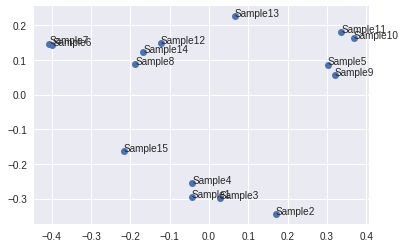

In [52]:
from skbio.stats import ordination
#use the special distance matrix format as the input matrix for the pcoa function (bc_matrix)
MDS = ordination.pcoa(bc_matrix)

#Plot a figure visualizing 2-D distance between samples using the first two ordinatation axes

%matplotlib inline
plt.plot(MDS.samples['PC1'],MDS.samples['PC2'], lw=0, marker = 'o')

#Add labels to the graph so you know which samples are clustering
for x in np.arange(0,len(MDS.samples['PC1'])):
    plt.text(MDS.samples.PC1[x],MDS.samples.PC2[x],sample_list[x])

## Identify clusters of samples and test whether they are significantly different
- here we are using k-means clustering.  You could also use the clustering method explained further down
- k-means clustering requires an apriori defined number of clusters to identify
- output of k-means clustering is a list of the corresponding group that each sample belongs to.

In [53]:
from sklearn.cluster import KMeans

#This function requires the square-shaped bray-curtis similarity array, without specialized formating
kmeans = KMeans(n_clusters=3, random_state=0).fit(bc_matrix_square)
kmeans.labels_

array([2, 2, 2, 2, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 2], dtype=int32)

In [54]:
#test whether differences among groups are significant.
permanova_test = skbio.stats.distance.permanova(bc_matrix,kmeans.labels_)
permanova_test

method name               PERMANOVA
test statistic name        pseudo-F
sample size                      15
number of groups                  3
test statistic              8.25456
p-value                       0.001
number of permutations          999
Name: PERMANOVA results, dtype: object

## Explore which species might be driving significant differences among groups of samples
- Here we use a "simper" analysis to idenify which species contribute the most to the the percent dissimilarity between two groups of samples
- We are using the simper analysis function in the ecopy library of functions
- We are using the k-means clustering results to define groups of samples
- Here, we print out the top ten species contributing to differences among groups
- Simper is not an especially robust statistical analysis, but helps point you toward the species driving differences among groups found through more robust approaches (like PERMANOVA)

In [56]:
from Phytoplankton_Taxomony_Course/simper_edited_fromEcopy import simper
species_driving_differences = ecopy.simper(np.asarray(cells_per_mL.T),kmeans.labels_)
#print(species_driving_differences.iloc['0-1'][1:10])
#print(species_driving_differences.iloc['0-2'][1:10])
#print(species_driving_differences.ix['1-2'][1:10])

SyntaxError: ignored

## Alternative clustering approaches
- heierarchical clustering and visualization using a dendrogram

{'color_list': ['g',
  'g',
  'g',
  'r',
  'c',
  'c',
  'c',
  'b',
  'm',
  'm',
  'b',
  'b',
  'b',
  'b'],
 'dcoord': [[0.0, 0.14061384725196288, 0.14061384725196288, 0.0],
  [0.0, 0.27671641271968556, 0.27671641271968556, 0.14061384725196288],
  [0.0, 0.3223284777127483, 0.3223284777127483, 0.27671641271968556],
  [0.0, 0.14871415660175827, 0.14871415660175827, 0.0],
  [0.0, 0.21640091116173116, 0.21640091116173116, 0.0],
  [0.0, 0.262483359675612, 0.262483359675612, 0.21640091116173116],
  [0.0, 0.27759837832022183, 0.27759837832022183, 0.262483359675612],
  [0.14871415660175827,
   0.43094984435649725,
   0.43094984435649725,
   0.27759837832022183],
  [0.0, 0.1955484896661367, 0.1955484896661367, 0.0],
  [0.0, 0.317089666666739, 0.317089666666739, 0.1955484896661367],
  [0.0, 0.43923137114844396, 0.43923137114844396, 0.317089666666739],
  [0.43094984435649725,
   0.4400751258465058,
   0.4400751258465058,
   0.43923137114844396],
  [0.3223284777127483,
   0.5068738376771578,


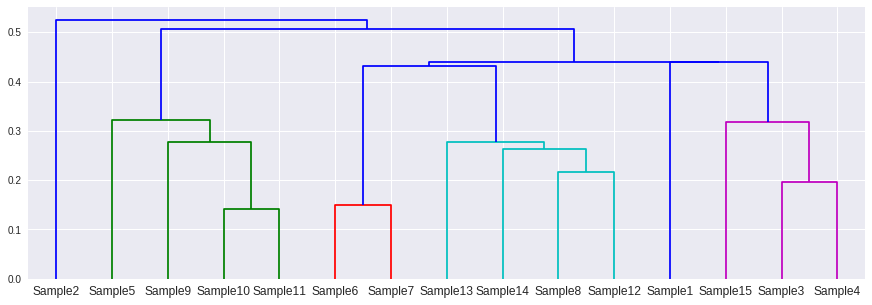

In [31]:
from scipy.cluster.hierarchy import dendrogram, linkage

#this function requires the condensed format of our bray-curtis similarity index
linkage_matrix = linkage(bc_matrix_condensed, "centroid")
plt.figure(figsize=[15,5])
dendrogram(linkage_matrix, labels=sample_list)
